# Compare models with diff delays

In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


In [24]:
mouse_id = 'Mouse12'
session_id = '120806'
phase = 'wake'
subset = 'hdc'

bin_size = 160  # ms
single_spikes = False

delay = -1
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/' 

In [25]:
dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

units:  85  hdc units:  22


In [33]:
model_dict = {
                'seed': 123, 
                'll_mode': 'U-eq-2',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [-3, -2, -1, 1, 2, 3], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }  

modelfit, training_results, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev)

In [27]:
units_used = dataset_dict['neurons']

rcov = np.empty((0, dataset_dict['covariates']['hd'].shape[0]))

for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    rcov = np.concatenate((rcov, dataset_dict['covariates'][cov][None, :]), axis=0)
 

hd_sweep = torch.linspace(0, 2*np.pi, 100)

covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean()*torch.ones((100, 1)) for k in range(1, len(rcov))], 
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

In [28]:
K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

_, hd_rate, _ = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
_, hd_FF, _ = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])

Text(0, 0.5, 'Fano Factor')

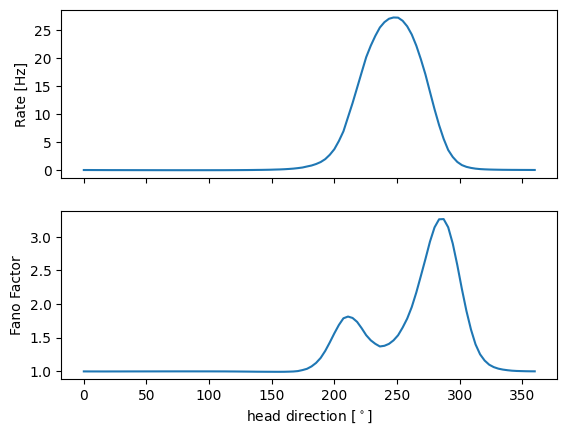

In [30]:
ne = 4
fig, ax = plt.subplots(2, 1, sharex=True)

angles = np.linspace(0, 360, hd_mean.shape[-1])

ax[0].plot(angles, hd_rate[ne,:])
ax[0].set_ylabel('Rate [Hz]')
ax[1].plot(angles, hd_FF[ne,:])
ax[1].set_xlabel('head direction [$^\circ$]')
ax[1].set_ylabel('Fano Factor')

In [31]:
correlations = np.empty((0,))

for ne in range(units_used):
    C = np.corrcoef(np.gradient(hd_rate[ne,:])**2, hd_FF[ne,:])
    correlations = np.append(correlations, C[0,1])

fig, ax = plt.subplots()
ax.hist(correlations[:22], bins='auto')
ax.set_xlabel('correlation coefficient')
ax.set_ylabel('number of neurons')